<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/lern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
!pip install pandas-ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

**Define functions**

In [55]:
def get_largest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the apply() function with the max() function to find the maximum value in each row of the subsetted data frame
    max_values = sub_data.apply(max, axis=1)

    # Create a new array that takes the maximum value from step 2 for each row of the original data frame
    max_array = np.array(max_values)
    
    return max_array
  
def get_smallest_value_array(Data, columns):
    # Subset the data frame to only include the specified columns
    sub_data = Data[columns]

    # Use the min() function to find the minimum value in each row of the subsetted data frame
    min_values = sub_data.min(axis=1)

    # Create a new array that takes the minimum value from step 2 for each row of the original data frame
    min_array = np.array(min_values)
    
    return min_array

def get_array_bo_greater_than_bc(Data):
    # Use np.where() to compare the "BO" and "BC" columns, return 1 if "BO" < "BC", and 0 otherwise
    result_array = np.where(Data["BO"] < Data["BC"], 1, 0)
    
    return result_array

def generate_dataframe(func, start, end, step, data, name):
    result_df = pd.DataFrame()

    for param in np.arange(start, end, step):
        result_array = func(param, data)
        temp_df = pd.DataFrame(result_array, columns=[name+str(param)])
        result_df = pd.concat([result_df, temp_df], axis=1)

    return result_df

**Load Data**

In [25]:
Data = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Time'] = pd.to_datetime(Data['Time'])
print(Data)

            Date                Time       BO       BH       BL       BC  \
0     2005-05-02 2023-05-23 00:00:00  1.28520  1.28520  1.28400  1.28440   
1     2005-05-02 2023-05-23 01:00:00  1.28440  1.28480  1.28390  1.28420   
2     2005-05-02 2023-05-23 02:00:00  1.28430  1.28540  1.28410  1.28510   
3     2005-05-02 2023-05-23 03:00:00  1.28510  1.28590  1.28500  1.28510   
4     2005-05-02 2023-05-23 04:00:00  1.28520  1.28590  1.28490  1.28550   
...          ...                 ...      ...      ...      ...      ...   
93079 2020-04-29 2023-05-23 18:00:00  1.08620  1.08851  1.08611  1.08713   
93080 2020-04-29 2023-05-23 19:00:00  1.08711  1.08823  1.08659  1.08748   
93081 2020-04-29 2023-05-23 20:00:00  1.08747  1.08788  1.08691  1.08708   
93082 2020-04-29 2023-05-23 21:00:00  1.08708  1.08740  1.08699  1.08714   
93083 2020-04-29 2023-05-23 22:00:00  1.08728  1.08760  1.08727  1.08743   

           BCh       AO       AH       AL       AC      ACh  
0     -0.00080  1.28540  

**Extract time information**

In [26]:
Date = pd.DataFrame()

Date['day'] = Data['Date'].dt.day
Date['month'] = Data['Date'].dt.month
Date['weekday'] = Data['Date'].dt.weekday
Date['hour_of_day'] = Data['Time'].dt.hour

print(Date)

       day  month  weekday  hour_of_day
0        2      5        0            0
1        2      5        0            1
2        2      5        0            2
3        2      5        0            3
4        2      5        0            4
...    ...    ...      ...          ...
93079   29      4        2           18
93080   29      4        2           19
93081   29      4        2           20
93082   29      4        2           21
93083   29      4        2           22

[93084 rows x 4 columns]


**Candle stick and other chart info**

In [69]:
Shape = pd.DataFrame()

abs_diff_array = np.abs(Data['BH'] - Data['BL'])

updown_array = get_array_bo_greater_than_bc(Data)

max_array = get_largest_value_array(Data,["BC", "BO"])
min_array = get_smallest_value_array(Data,["BC", "BO"])

tp_array = (Data['BH']-min_array)/abs_diff_array
bp_array = (Data['BH']-max_array)/abs_diff_array

RelChange = Data['BC'] - Data['BO']

Shape["Direction"] = updown_array
Shape["Bottom_Point"] = bp_array
Shape["Top_Point"] = tp_array
Shape["Relative_Change"] = RelChange
Shape["Size"] = abs_diff_array




print(Shape)

       Direction  Bottom_Point  Top_Point  Relative_Change     Size
0              0      0.000000   0.666667         -0.00080  0.00120
1              0      0.444444   0.666667         -0.00020  0.00090
2              1      0.230769   0.846154          0.00080  0.00130
3              0      0.888889   0.888889          0.00000  0.00090
4              1      0.400000   0.700000          0.00030  0.00100
...          ...           ...        ...              ...      ...
93079          1      0.575000   0.962500          0.00093  0.00240
93080          1      0.457317   0.682927          0.00037  0.00164
93081          0      0.422680   0.824742         -0.00039  0.00097
93082          1      0.634146   0.780488          0.00006  0.00041
93083          1      0.515152   0.969697          0.00015  0.00033

[93084 rows x 5 columns]


**Technical analysis**

(2000.0, 2500.0)

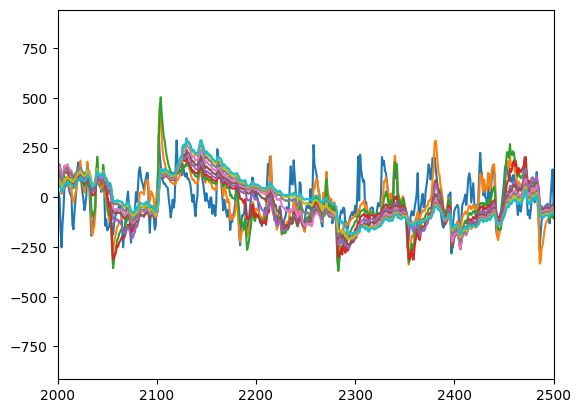

In [77]:

OHLC = Data[["BC","BL","BH","BO"]]


def sma_func(hyperparameter, data):
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    close = data["BC"]
    sma_result = ta.sma(close, length=hyperparameter)-close

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def stdev_func(hyperparameter, data):
    close = data["BC"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.stdev(close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def rsi_func(hyperparameter, data):
    close = data["BC"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.rsi(close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array

def cci_func(hyperparameter, data):
    close = data["BC"]
    high = data["BH"]
    low = data["BL"]
    # Calculate the Simple Moving Average (SMA) using the ta.sma() function
    sma_result = ta.cci(high,low,close, length=hyperparameter)

    # Convert the resulting Series to a NumPy array
    result_array = sma_result.to_numpy()

    return result_array


rsi = generate_dataframe(rsi_func,10,50,5,OHLC,"RSI_")

sma1 = generate_dataframe(sma_func,10,100,10,OHLC,"SMA_")
sma2 = generate_dataframe(sma_func,100,500,50,OHLC,"SMA_")

stdev = generate_dataframe(stdev_func,10,200,10,OHLC,"STDEV_")

cci = generate_dataframe(cci_func,10,200,20,OHLC,"CCI_")


Technicals = pd.concat([sma1, sma2, stdev,rsi,cci], axis=1)

#print(stdev1)

plt.plot(cci)
plt.xlim(2000,2500)
#plt.ylim(-.05,.05)

**Combine dataframes and prepare data**

In [81]:
fulldata = pd.concat([Date,Shape,Technicals,],axis=1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(fulldata)
scaled_df = pd.DataFrame(scaled_data, columns=fulldata.columns)
#print(fulldata)
plt.plot(fulldata)

NameError: ignored